## 2. Unsupervised and Supervised Learning with FTIR and 13C NMR

2.2 Unsupervised Learning: K-Means Clustering
---
To rapidly assess whether "natural" classification or clustering exists, an unsupervised k-means clustering analysis was performed on on the 2D FTIR/13C NMR dataset. The number of clusters (k) was varied, and subsequently compared to the ground truth labels.

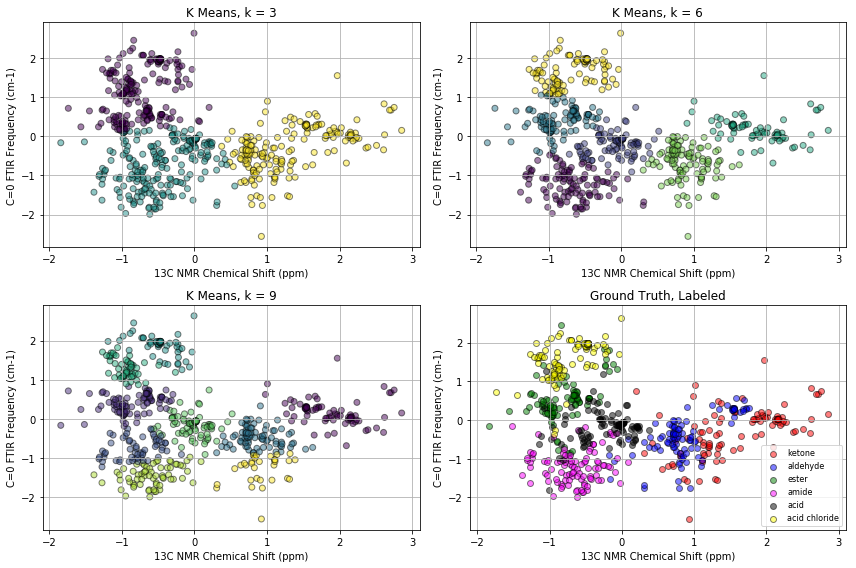

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn import preprocessing


%matplotlib inline

DATA_PATH = "Data/carbonyl.csv"
# Provide dictionary for label codes
LABEL_DICT = {0: 'ketone', 1: 'aldehyde', 2: 'ester', 3: 'amide', 4: 'acid', 5:'acid chloride'}

# Load carbonyl datafile as Pandas dataframe
carb_df = pd.read_csv(DATA_PATH)
std_scale = preprocessing.StandardScaler().fit(carb_df[['Carbon', 'Infrared']])
df_std = std_scale.transform(carb_df[['Carbon', 'Infrared']])

# define K-means cluster sizes
cluster_sizes = [3, 6, 9]

plt.clf()
fig = plt.subplots(2,2, figsize =(12,8))

# Plot three K-Means clusters in firt three subplot locations
for i,j in zip(range(1, len(cluster_sizes) + 1), cluster_sizes):
    plt.subplot(2, 2, i)
    est = KMeans(n_clusters = j)
    est.fit(df_std)
    labels = est.labels_
    plt.title('K Means, k = %s' %j)
    plt.scatter(df_std[:, 0], 
                df_std[:, 1], 
                c=labels.astype(np.float), 
                edgecolor='black',
                alpha=0.5)
    plt.xlabel('13C NMR Chemical Shift (ppm)')
    plt.ylabel('C=0 FTIR Frequency (cm-1)')
    plt.grid(True)
    plt.tight_layout

# Plot ground truth labeled data in bottom-right of subplot    
for i,c in zip(range(0,6), 
               ('red', 'blue', 'green', 'magenta', 'black','yellow')):
    plt.subplot(2, 2, 4)
    plt.scatter(df_std[carb_df['Label'].values == i, 0],
                df_std[(carb_df['Label'].values == i, 1)],
                alpha=0.5,
                color=c, 
                edgecolor='black',
                label = LABEL_DICT[i])
    plt.title('Ground Truth, Labeled')
    plt.xlabel('13C NMR Chemical Shift (ppm)')
    plt.ylabel('C=0 FTIR Frequency (cm-1)')
    plt.legend(loc='best', prop={'size':8})
    plt.grid(True)
    plt.tight_layout()

2.3 Supervised Learning: Classification with FT-IR/13C NMR
---

The two-feature FT-IR/13C NMR dataset could further be analyzed through supervised classification methods; two support vector machines, a logistic regression classifier and random forests classifier are shown below.

Below, a randomized 80/20 training set/test set split is employed. Utilizing the training set for feature normalization, the classifiers can be fit and their decision boundaries plotted, as shown below.

[### Validation set or kfold?]

In [122]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix

# Import plotting helper functions
import plot_utils

# Create a randomized 80/20 training/test Split
carb_train, carb_test = sk.model_selection.train_test_split(carb_df, 
                                                            test_size=0.2)

# calculate mean normalization w/ unit variance on training set
std_scale = sk.preprocessing.StandardScaler().fit(carb_train[['Carbon',
                                                              'Infrared']])

# apply to create standardized training and test sets with labels
train_std = std_scale.transform(carb_train[['Carbon', 'Infrared']])
test_std = std_scale.transform(carb_test[['Carbon', 'Infrared']])
train_labels = np.array(carb_train['Label'])
test_labels = np.array(carb_test['Label'])


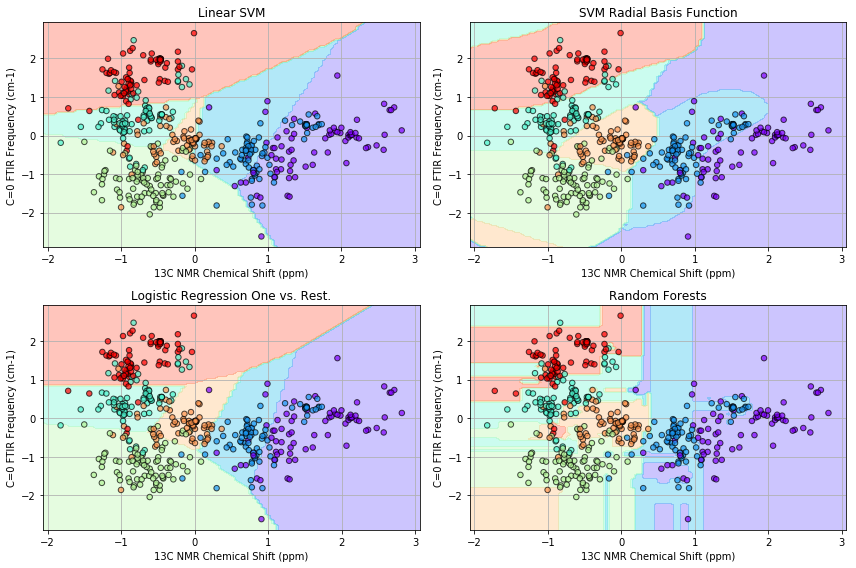

In [123]:
# Build classifiers

lin_svm = svm.LinearSVC(C=1.0)
rbf_svm = svm.SVC(kernel='rbf', gamma=0.8, C=1.0)
logr = LogisticRegression(solver='sag', 
                          max_iter=100,
                          multi_class='ovr')
rforest = RandomForestClassifier(n_jobs=-1, 
                                n_estimators=200, 
                                oob_score=True, 
                                max_features=None)

models = [lin_svm, rbf_svm, logr, rforest]

# Fit the classifiers
lin_svm.fit(train_std, train_labels)
rbf_svm.fit(train_std, train_labels)
logr.fit(train_std, train_labels)
rforest.fit(train_std, train_labels)

# Plot titles
titles = ['Linear SVM',
          'SVM Radial Basis Function',
          'Logistic Regression One vs. Rest.',
          'Random Forests']

plt.subplots(2,2, figsize=(12,8))
for i, classifier in enumerate(models):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.xlabel('13C NMR Chemical Shift (ppm)')
    plt.ylabel('C=0 FTIR Frequency (cm-1)')
    plot_utils.plotDecisionBoundary(classifier,
                                   train_std,
                                   train_labels)
    plt.grid(True)
    plt.tight_layout()


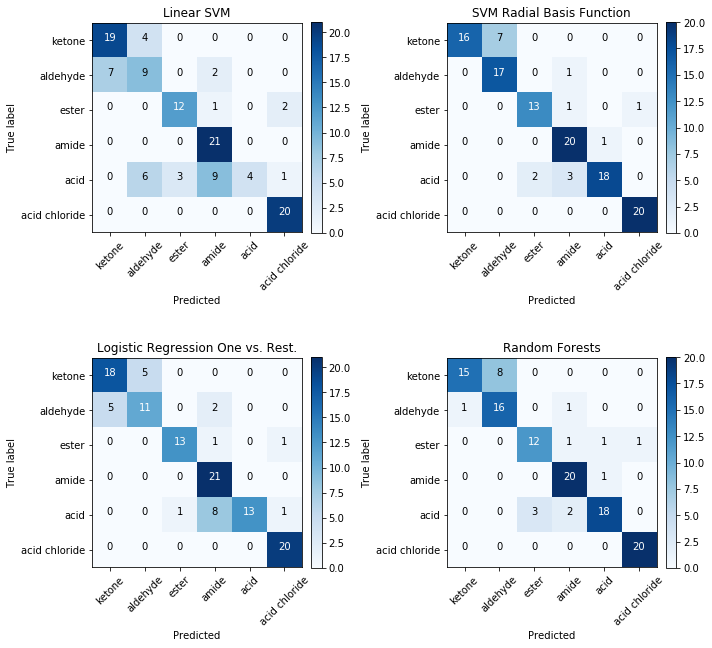

In [124]:
# Generate predictions and confusion matrix
predictions = []
cfn_matrices = []
for model in models:
    mod_pred = model.predict(test_std)
    predictions.append(mod_pred)
    cfn_matrices.append(confusion_matrix(test_labels, mod_pred))

# Plot confusion matrices and test scores

plt.subplots(2,2, figsize=(10, 10))
for i, matrix in enumerate(cfn_matrices):
    plt.subplot(2, 2, i + 1)
    plot_utils.plot_confusion_matrix(matrix, 
                                     LABEL_DICT.values(),
                                     pltTitle=titles[i])


In [8]:
# Calculate kfold validation, test scores
test_scores = []
kfold_scores = []

# Build a k-fold cross validation score for logistic classifier
kfold = model_selection.KFold(n_splits=10)

for model in models:
    kfold_results = model_selection.cross_val_score(model, 
                                                    train_std, 
                                                    train_labels,
                                                    cv=kfold)
    test_score = model.score(test_std, test_labels)
    kfold_scores.append(kfold_results)
    test_scores.append(test_score)

for title, kfold, test in zip(titles,
                              kfold_scores,
                              test_scores):
    print(title)
    if title == "Random Forests":
        print("Out of the Bag Score: %.3f" % rforest.oob_score_)
    else:
        print("K-Fold CV Score: %.3f" % (np.mean(kfold)))
    print("Test Score: %.3f\n" % (test))

Linear SVM
K-Fold CV Score: 0.685
Test Score: 0.658

SVM Radial Basis Function
K-Fold CV Score: 0.829
Test Score: 0.825

Logistic Regression One vs. Rest.
K-Fold CV Score: 0.756
Test Score: 0.733

Random Forests
Out of the Bag Score: 0.819
Test Score: 0.850



### 2.3 Examining the Structure of Misclassified Examples


In [125]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

# Look at misclassified examples in the random forests classifier

rfc_pred = rforest.predict(test_std)

missed = np.where(rfc_pred != test_labels)
mols = []
pred_act = []

for idx in missed[0]:
    pred_act.append("Predicted: " + str(LABEL_DICT[rfc_pred[idx]]) + "," +
                    "Actual: " + str(LABEL_DICT[test_labels[idx]]))
    mols.append(carb_test['SMILES'].iloc[idx])

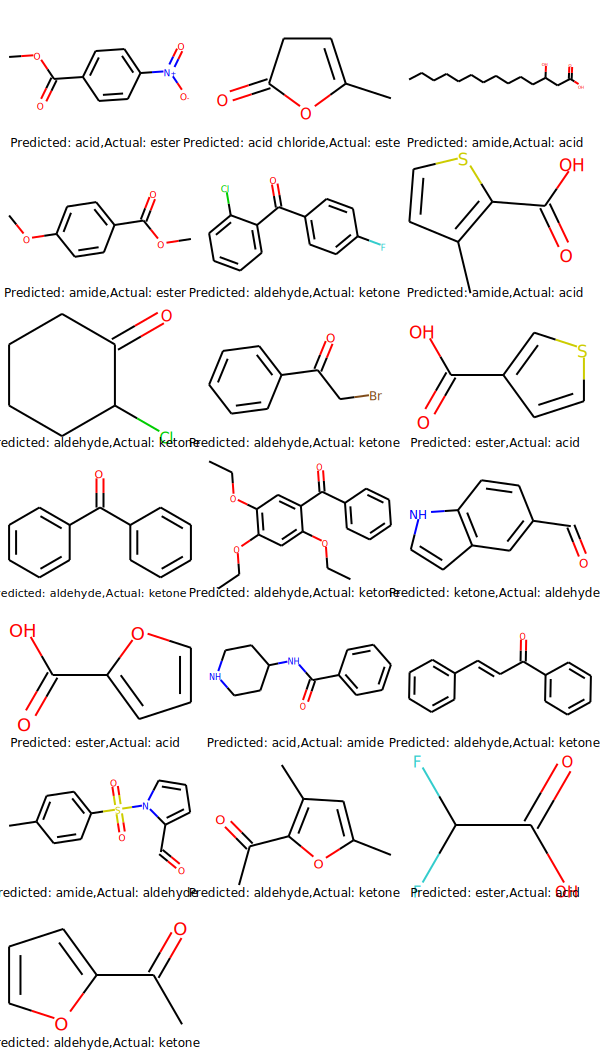

In [126]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in mols], 
                     molsPerRow=3,
                     subImgSize=(200,150),
                     legends=pred_act)